In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
import os

import keras
keras.__version__

'2.9.0'

In [25]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.utils import img_to_array, load_img, array_to_img, to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.optimizers import SGD, Adam


In [4]:
# funkcje pomocnicze
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
features_pd = pd.read_csv('CelebFaces_dataset/list_attr_celeba.csv')
features_pd.set_index('image_id', inplace=True)
features_pd.replace(to_replace=-1, value=0, inplace=True) #replace -1 to 0
print(features_pd.shape)

features_pd.head().T

(202599, 40)


image_id,000001.jpg,000002.jpg,000003.jpg,000004.jpg,000005.jpg
5_o_Clock_Shadow,0,0,0,0,0
Arched_Eyebrows,1,0,0,0,1
Attractive,1,0,0,1,1
Bags_Under_Eyes,0,1,0,0,0
Bald,0,0,0,0,0
Bangs,0,0,0,0,0
Big_Lips,0,0,1,0,1
Big_Nose,0,1,0,0,0
Black_Hair,0,0,0,0,0
Blond_Hair,0,0,0,0,0


Balanced YES/NO in: 0.9308014867054226


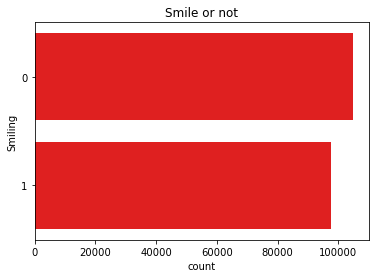

In [8]:
plt.title("Smile or not")
sns.countplot(y = "Smiling", data = features_pd, color = "r")
plt.show

print(f"Balanced YES/NO in: {(features_pd['Smiling'].value_counts()[1])/(features_pd['Smiling'].value_counts()[0])}")

In [9]:
partition_df = pd.read_csv('CelebFaces_dataset/list_eval_partition.csv')
partition_df.head()


,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [10]:
partition_df['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [11]:
partition_df.set_index('image_id', inplace=True)

In [12]:
df_atr_par = partition_df.join(features_pd['Smiling'], how='inner')
df_atr_par.head()

,partition,Smiling
image_id,,
000001.jpg,0,1
000002.jpg,0,1
000003.jpg,0,0
000004.jpg,0,0
000005.jpg,0,0


In [13]:
df_atr_par.value_counts().sort_index()

partition  Smiling
0          0          84690
           1          78080
1          0          10265
           1           9602
2          0           9975
           1           9987
dtype: int64

In [15]:
#reshape function 

def load_reshape_img(f_name):
    img = load_img(f_name)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)
    return x

In [16]:
df_train_0 = df_atr_par[(df_atr_par['partition']==0) & (df_atr_par['Smiling']==0)].sample(n=5000)
df_train_1 = df_atr_par[(df_atr_par['partition']==0) & (df_atr_par['Smiling']==1)].sample(n=5000)
df_train = pd.concat([df_train_0, df_train_1])

In [17]:
x_train = np.array([load_reshape_img(f'CelebFaces_dataset/img_align_celeba/img_align_celeba/{f_name}') for f_name in df_train.index])

In [18]:
x_train = x_train.reshape(x_train.shape[0], 218, 178, 3)


In [20]:
x_train.shape

(10000, 218, 178, 3)

In [21]:
y_train = np.array(df_train["Smiling"])

In [22]:
y_train = to_categorical(y_train)

In [26]:
#data agumentation

data_gener =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

data_gener.fit(x_train)

train_generator = data_gener.flow(
x_train, y_train,
batch_size=16,
)

In [27]:
df_val_0 = df_atr_par[(df_atr_par['partition']==1) & (df_atr_par['Smiling']==0)].sample(n=1000)
df_val_1 = df_atr_par[(df_atr_par['partition']==1) & (df_atr_par['Smiling']==1)].sample(n=1000)
df_val = pd.concat([df_val_0, df_val_1])

x_val = np.array([load_reshape_img(f'CelebFaces_dataset/img_align_celeba/img_align_celeba/{f_name}') for f_name in df_val.index])
x_val = x_val.reshape(x_val.shape[0], 218, 178, 3)

y_val = np.array(df_val["Smiling"])
y_val = to_categorical(y_val)


In [50]:
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense

model = Sequential()
model.add(Conv2D(8, (3, 3), padding="same",input_shape=(218,178,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(2, activation="softmax"))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_112 (Conv2D)         (None, 218, 178, 8)       224       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 72, 59, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_113 (Conv2D)         (None, 72, 59, 16)        1168      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 36, 29, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_114 (Conv2D)         (None, 36, 29, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 18, 14, 32)      

In [51]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0005),metrics=['accuracy'])
ist = model.fit(train_generator
                     , validation_data = (x_val, y_val)
                      , steps_per_epoch= 10000/16
                      , epochs= 10
                      , verbose=1
                          
                    )

Epoch 1/10
625/625 [==============================] - 201s 321ms/step - loss: 0.6938 - accuracy: 0.4943 - val_loss: 0.6934 - val_accuracy: 0.4850
Epoch 2/10
625/625 [==============================] - 182s 291ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6933 - val_accuracy: 0.4885
Epoch 3/10
625/625 [==============================] - 180s 289ms/step - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6934 - val_accuracy: 0.4885
Epoch 4/10
625/625 [==============================] - 181s 290ms/step - loss: 0.6932 - accuracy: 0.4946 - val_loss: 0.6935 - val_accuracy: 0.4900
Epoch 5/10
625/625 [==============================] - 187s 300ms/step - loss: 0.6932 - accuracy: 0.4932 - val_loss: 0.6934 - val_accuracy: 0.4890
Epoch 6/10
625/625 [==============================] - 203s 325ms/step - loss: 0.6932 - accuracy: 0.4928 - val_loss: 0.6934 - val_accuracy: 0.4845
Epoch 7/10
625/625 [==============================] - 196s 313ms/step - loss: 0.6932 - accuracy: 0.4960 - val_loss: 0.6934 -

In [30]:

from tensorflow.keras.applications.inception_v3 import InceptionV3

inc_model = InceptionV3(weights='/Users/dawidweber/Desktop/Data Science - praca własna/CelebFaces_dataset/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(218, 178, 3))

print("number of layers:", len(inc_model.layers))

2022-08-09 12:36:30.775637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


number of layers: 311


In [31]:
#Adding Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [32]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

/Users/dawidweber/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [34]:
hist = model_.fit_generator(train_generator
                     , validation_data = (x_val, y_val)
                      , steps_per_epoch= 10000/16
                      , epochs= 10
                      , verbose=1
                    )

/var/folders/pk/yw16hg2n17d3k_b_4jhjg8400000gn/T/ipykernel_11504/1928118229.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_.fit_generator(train_generator


Epoch 1/10
625/625 [==============================] - 1289s 2s/step - loss: 0.7135 - accuracy: 0.5305 - val_loss: 0.7212 - val_accuracy: 0.4895
Epoch 2/10
625/625 [==============================] - 1294s 2s/step - loss: 0.6686 - accuracy: 0.5932 - val_loss: 0.9188 - val_accuracy: 0.4980
Epoch 3/10
625/625 [==============================] - 1367s 2s/step - loss: 0.6446 - accuracy: 0.6337 - val_loss: 0.9105 - val_accuracy: 0.5005
Epoch 4/10
625/625 [==============================] - 2002s 3s/step - loss: 0.6077 - accuracy: 0.6648 - val_loss: 0.8525 - val_accuracy: 0.4955
Epoch 5/10
625/625 [==============================] - 1400s 2s/step - loss: 0.5652 - accuracy: 0.7092 - val_loss: 0.7746 - val_accuracy: 0.4975
Epoch 6/10
625/625 [==============================] - 1326s 2s/step - loss: 0.5230 - accuracy: 0.7378 - val_loss: 0.7543 - val_accuracy: 0.5035
Epoch 7/10
625/625 [==============================] - 1336s 2s/step - loss: 0.4868 - accuracy: 0.7656 - val_loss: 0.7405 - val_accuracy: